# Clean the U.S. Education Dataset 
The U.S. Education Dataset was taken from Kaggle ([project page](https://www.kaggle.com/noriuk/us-education-datasets-unification-project)) and it contains detailed state-level information on several facets of education (e.g., education outcomes, revenues, expenditures, etc.) in the United States on an annual basis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

%matplotlib inline

## Load the data

In [2]:
# PostgreSQL credentials
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "useducation"

# Read the data from the useducation table
engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

education = pd.read_sql_query("select * from useducation", con=engine)

In [3]:
# Inspect first 5 rows
education.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


## Deal with missing values

1. Determine all the variable types and find the fraction of the missing values for each variable.

In [4]:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In the `useducation` table, there are only two nominal categorical variables: the primary key (`PRIMARY_KEY`) and the state names (`STATE`). All the other variables are continuous ratio data. Shown below is the fraction of missing values for each variable.

In [5]:
education.isnull().sum() / education.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.176273
TOTAL_REVENUE                   0.142091
FEDERAL_REVENUE                 0.142091
STATE_REVENUE                   0.142091
LOCAL_REVENUE                   0.142091
TOTAL_EXPENDITURE               0.142091
INSTRUCTION_EXPENDITURE         0.142091
SUPPORT_SERVICES_EXPENDITURE    0.142091
OTHER_EXPENDITURE               0.176273
CAPITAL_OUTLAY_EXPENDITURE      0.142091
GRADES_PK_G                     0.115952
GRADES_KG_G                     0.088472
GRADES_4_G                      0.087802
GRADES_8_G                      0.087802
GRADES_12_G                     0.087802
GRADES_1_8_G                    0.087802
GRADES_9_12_G                   0.087802
GRADES_ALL_G                    0.115952
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

2. Forget about the time dimension (year) for now and choose a strategy to deal with missing values for each variable. (For which variables would filling in the missing values with some value make sense? For which might tossing out the records entirely make sense?)

For revenues, grades, and expenditures (all continuous ratio variables), we can fill in the missing values using the respective medians. Since average math and reading scores have too many missing values, it's neither appropriate to impute the values or toss out rows with missing values.

In [6]:
# Create an empty dataframe with the same dimension
education2 = pd.DataFrame().reindex_like(education)

# Copy columns that won't change
for column in education.columns[:3].tolist() + education.columns[-5:].tolist():
    education2[column] = education[column]

# Replace missing values with medians and save to the new dataframe
for column in education.columns[3:-4]:
    education2[column] = education[column].fillna(education[column].median())

3. Now, take into account of the time factor and fill in missing values using observations from each specific year.

In [7]:
# Create another empty dataframe with the same dimension
education3 = pd.DataFrame().reindex_like(education)

# Copy columns that won't change
for column in education.columns[:3].tolist() + education.columns[-5:].tolist():
    education3[column] = education[column]

# Replace missing values with medians from the same year
for column in education.columns[3:-4]:
    for year in education["YEAR"].unique():
        education3.loc[education3["YEAR"] == year, column] = education.loc[
            education["YEAR"] == year, column
        ].fillna(education.loc[education["YEAR"] == year, column].median())

In [8]:
education3.isnull().sum() / education3.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.071716
TOTAL_REVENUE                   0.034182
FEDERAL_REVENUE                 0.034182
STATE_REVENUE                   0.034182
LOCAL_REVENUE                   0.034182
TOTAL_EXPENDITURE               0.034182
INSTRUCTION_EXPENDITURE         0.034182
SUPPORT_SERVICES_EXPENDITURE    0.034182
OTHER_EXPENDITURE               0.071716
CAPITAL_OUTLAY_EXPENDITURE      0.034182
GRADES_PK_G                     0.068365
GRADES_KG_G                     0.068365
GRADES_4_G                      0.068365
GRADES_8_G                      0.068365
GRADES_12_G                     0.068365
GRADES_1_8_G                    0.068365
GRADES_9_12_G                   0.068365
GRADES_ALL_G                    0.068365
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

4. This time, fill in the missing values using interpolation (extrapolation).

In [9]:
# Interpolate missing values using the mean of adjacent values
education4 = education.interpolate(method="linear", limit_direction="forward", limit=1)

# Inspect first 5 rows
education4.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,211.790904,258.776900,207.088116,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,265.519676


5. Compare your results for the 2nd, 3rd, and 4th questions. Do you find any meaningful differences?

Different methods fill in different proportions of missing values in different ways. The first method uses medians across all years to fill in missing values, which allows us to replace all missing values unless a column is completely empty. However, this method can be inappropriate if drastic changes happened from one year to another. This worry can be addressed by the second method where medians from the same year are used to fill in the missing values. However, if a specific year has no data, missing values from that year can't be replaced. The third method uses the mean of adjacent values of the missing value to replace it. This may not be appropriate if values are not equally spaced.

In [10]:
# Method 1: Use medians across all years
education2.isnull().sum() / education2.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.000000
TOTAL_REVENUE                   0.000000
FEDERAL_REVENUE                 0.000000
STATE_REVENUE                   0.000000
LOCAL_REVENUE                   0.000000
TOTAL_EXPENDITURE               0.000000
INSTRUCTION_EXPENDITURE         0.000000
SUPPORT_SERVICES_EXPENDITURE    0.000000
OTHER_EXPENDITURE               0.000000
CAPITAL_OUTLAY_EXPENDITURE      0.000000
GRADES_PK_G                     0.000000
GRADES_KG_G                     0.000000
GRADES_4_G                      0.000000
GRADES_8_G                      0.000000
GRADES_12_G                     0.000000
GRADES_1_8_G                    0.000000
GRADES_9_12_G                   0.000000
GRADES_ALL_G                    0.000000
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

In [11]:
# Method 2: Use medians from the same year
education3.isnull().sum() / education3.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.071716
TOTAL_REVENUE                   0.034182
FEDERAL_REVENUE                 0.034182
STATE_REVENUE                   0.034182
LOCAL_REVENUE                   0.034182
TOTAL_EXPENDITURE               0.034182
INSTRUCTION_EXPENDITURE         0.034182
SUPPORT_SERVICES_EXPENDITURE    0.034182
OTHER_EXPENDITURE               0.071716
CAPITAL_OUTLAY_EXPENDITURE      0.034182
GRADES_PK_G                     0.068365
GRADES_KG_G                     0.068365
GRADES_4_G                      0.068365
GRADES_8_G                      0.068365
GRADES_12_G                     0.068365
GRADES_1_8_G                    0.068365
GRADES_9_12_G                   0.068365
GRADES_ALL_G                    0.068365
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

In [12]:
# Method 3: Use the next value to fill in missing values
education4.isnull().sum() / education4.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.170912
TOTAL_REVENUE                   0.137399
FEDERAL_REVENUE                 0.137399
STATE_REVENUE                   0.137399
LOCAL_REVENUE                   0.137399
TOTAL_EXPENDITURE               0.137399
INSTRUCTION_EXPENDITURE         0.137399
SUPPORT_SERVICES_EXPENDITURE    0.137399
OTHER_EXPENDITURE               0.170912
CAPITAL_OUTLAY_EXPENDITURE      0.137399
GRADES_PK_G                     0.071046
GRADES_KG_G                     0.063003
GRADES_4_G                      0.063003
GRADES_8_G                      0.063003
GRADES_12_G                     0.063003
GRADES_1_8_G                    0.063003
GRADES_9_12_G                   0.063003
GRADES_ALL_G                    0.071046
AVG_MATH_4_SCORE                0.615282
AVG_MATH_8_SCORE                0.616622
AVG_READING_4_SCORE             0.618633
AVG_READING_8_SC

## Deal with outliers

Use appropriate techniques to deal with outliers and answer the following questions.

1. Consider the two variables: `TOTAL_REVENUE` and `TOTAL_EXPENDITURE`. Do these variables have outlier values?

First, we can use box plots and histograms to visualize potential outliers.

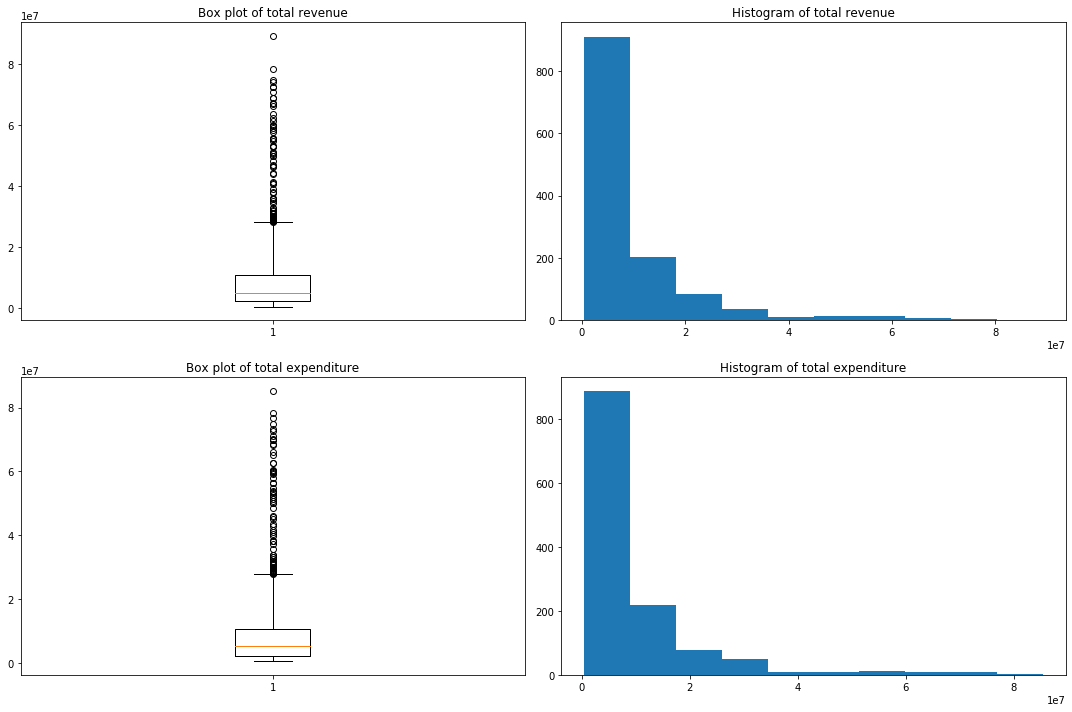

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.boxplot(education["TOTAL_REVENUE"].dropna(), whis=2)
plt.title("Box plot of total revenue")

plt.subplot(2, 2, 2)
plt.hist(education["TOTAL_REVENUE"].dropna())
plt.title("Histogram of total revenue")

plt.subplot(2, 2, 3)
plt.boxplot(education["TOTAL_EXPENDITURE"].dropna(), whis=2)
plt.title("Box plot of total expenditure")

plt.subplot(2, 2, 4)
plt.hist(education["TOTAL_EXPENDITURE"].dropna())
plt.title("Histogram of total expenditure")

plt.tight_layout()
plt.show()

Both total revenue and total expenditure seem to be around 10 million per year. A considerable amount of data far exceeds this number, ranging from 30 to 80 million per year. To find outliers in a more precise manner, we can calculate $Z$-scores and interquantile ranges (IQRs) of the two variables and set a threshold beyond which a data point is considered an outlier.

**$Z$-score**

In [14]:
# Z-scores of total revenue
z_revenue = zscore(education["TOTAL_REVENUE"].dropna())

# Z-scores of total expenditure
z_expend = zscore(education["TOTAL_EXPENDITURE"].dropna())

# Set threshold to be 3
print(
    "The number of outliers (Z-score > 3) in total revenue is: {}".format(
        len((np.where(z_revenue > 3)[0]))
    )
)

print(
    "The number of outliers (Z-score > 3) in total expenditure is: {}".format(
        len((np.where(z_expend > 3)[0]))
    )
)

The number of outliers (Z-score > 3) in total revenue is: 38
The number of outliers (Z-score > 3) in total expenditure is: 38


**Interquantile range**

In [15]:
# 1st and 3rd quantiles of total revenue and total expenditure
q75_revenue, q25_revenue = np.percentile(education["TOTAL_REVENUE"].dropna(), [75, 25])

q75_expend, q25_expend = np.percentile(
    education["TOTAL_EXPENDITURE"].dropna(), [75, 25]
)

# Interquantole range (IQR) of total revenue and total expenditure
iqr_revenue = q75_revenue - q25_revenue

iqr_expend = q75_expend - q25_expend

# Set threshold to be 1.5 IQR below 1st or above 3rd quantile
min_revenue = q25_revenue - (iqr_revenue * 1.5)

max_revenue = q25_revenue + (iqr_revenue * 1.5)

min_expend = q25_expend - (iqr_expend * 1.5)

max_expend = q25_expend + (iqr_expend * 1.5)

print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total revenue is: {}".format(
        len(
            (
                np.where(
                    (education["TOTAL_REVENUE"].dropna() > max_revenue)
                    | (education["TOTAL_REVENUE"].dropna() < min_revenue)
                )[0]
            )
        )
    )
)

print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total expenditure is: {}".format(
        len(
            (
                np.where(
                    (education["TOTAL_EXPENDITURE"].dropna() > max_expend)
                    | (education["TOTAL_EXPENDITURE"].dropna() < min_expend)
                )[0]
            )
        )
    )
)

The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total revenue is: 208
The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total expenditure is: 213


2. If you detect outliers in the `TOTAL_REVENUE` and `TOTAL_EXPENDITURE` variables, apply appropriate techniques to eliminate them and validate that there are no outlier values after you handled them.

Since no evidence suggests that outliers are due to measurement errors and there is a substantial amount of outliers, it may not be appropriate to simply remove them. We can use winsorization to cap extremely high values to the 90th percentile.

In [16]:
# Winsorize total revenue and total expenditure
winsorized_revenue = winsorize(education["TOTAL_REVENUE"].dropna(), limits=[0, 0.10])

winsorized_expend = winsorize(education["TOTAL_EXPENDITURE"].dropna(), limits=[0, 0.10])

Again, we can use visualizations (bar plots and histograms) and basic stats ($Z$-scores and IQR) to detect outliers.

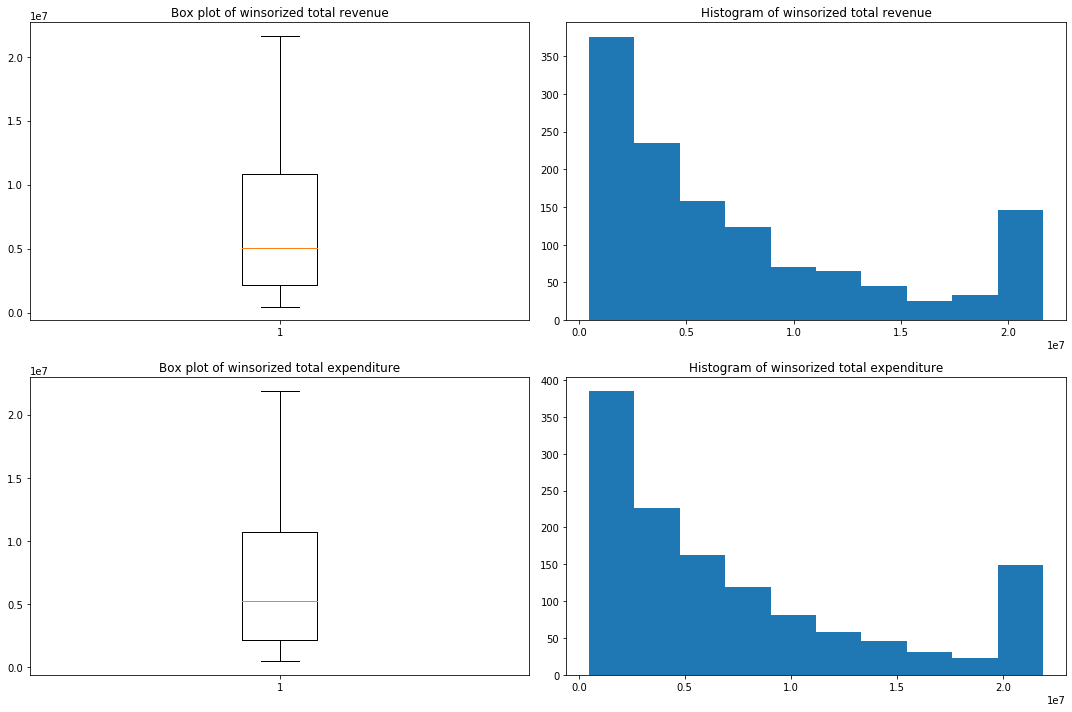

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.boxplot(winsorized_revenue, whis=2)
plt.title("Box plot of winsorized total revenue")

plt.subplot(2, 2, 2)
plt.hist(winsorized_revenue)
plt.title("Histogram of winsorized total revenue")

plt.subplot(2, 2, 3)
plt.boxplot(winsorized_expend, whis=2)
plt.title("Box plot of winsorized total expenditure")

plt.subplot(2, 2, 4)
plt.hist(winsorized_expend)
plt.title("Histogram of winsorized total expenditure")

plt.tight_layout()
plt.show()

No outliers are shown in the bar plots. In the histograms, a small proportion of values are capped at the upper bound.

In [18]:
print(
    "The number of outliers (Z-score > 3) in winsorized total revenue is: {}".format(
        len((np.where(zscore(winsorized_revenue) > 3)[0]))
    )
)

print(
    "The number of outliers (Z-score > 3) in winsorized total expenditure is: {}".format(
        len((np.where(zscore(winsorized_expend) > 3)[0]))
    )
)

The number of outliers (Z-score > 3) in winsorized total revenue is: 0
The number of outliers (Z-score > 3) in winsorized total expenditure is: 0


After winsorization, no values have a $Z$-score that is equal to or larger than 3.

In [19]:
print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in winsorized total revenue is: {}".format(
        len(
            np.where(
                (winsorized_revenue > max_revenue) | (winsorized_revenue < min_revenue)
            )[0]
        )
    )
)

print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in winsorized total expenditure is: {}".format(
        len(
            (
                np.where(
                    (winsorized_expend > max_expend) | (winsorized_expend < min_expend)
                )
            )[0]
        )
    )
)

The number of outliers (1.5 IQR below 1st or above 3rd quantile) in winsorized total revenue is: 208
The number of outliers (1.5 IQR below 1st or above 3rd quantile) in winsorized total expenditure is: 213


Strangely however, exactly the same amount of data points lie 1.5 IQR below the 1st or above the 3rd quantile, even though I used IQRs calculated from the original data. This must be that the 90th percentile is still 1.5 IQR above the 3rd quantile.

We can also use log transformations on the original data to reduce outliers.

In [20]:
log_revenue = np.log(education["TOTAL_REVENUE"].dropna())

log_expend = np.log(education["TOTAL_EXPENDITURE"].dropna())

Let's take a look again at outliers.

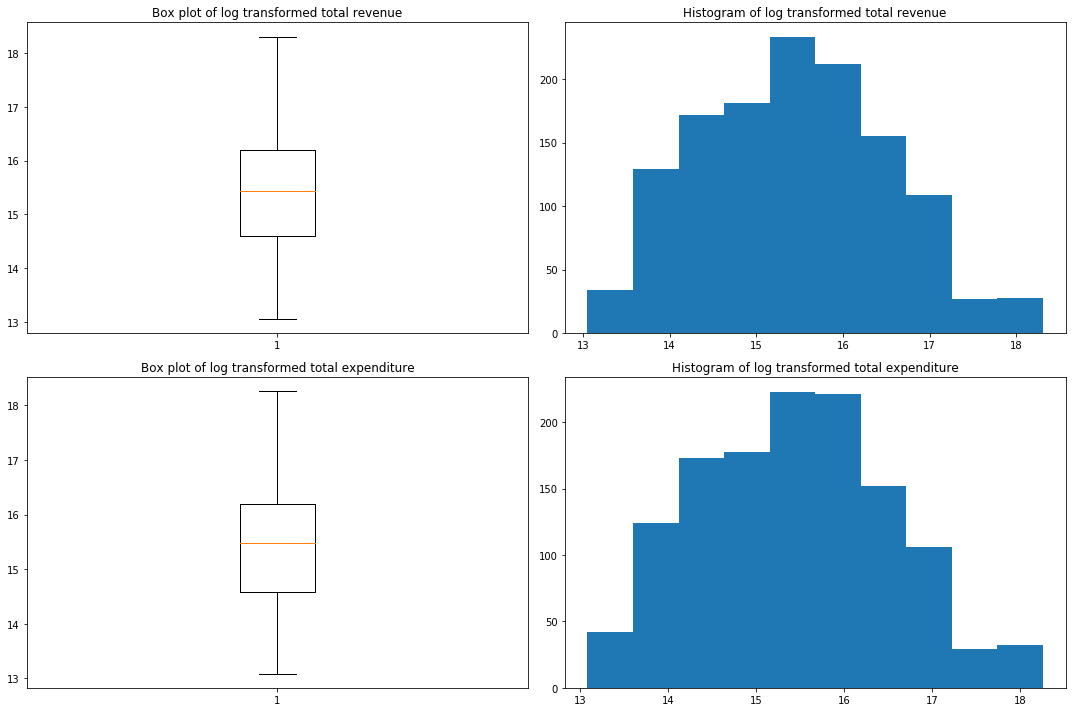

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.boxplot(log_revenue, whis=2)
plt.title("Box plot of log transformed total revenue")

plt.subplot(2, 2, 2)
plt.hist(log_revenue)
plt.title("Histogram of log transformed total revenue")

plt.subplot(2, 2, 3)
plt.boxplot(log_expend, whis=2)
plt.title("Box plot of log transformed total expenditure")

plt.subplot(2, 2, 4)
plt.hist(log_expend)
plt.title("Histogram of log transformed total expenditure")

plt.tight_layout()
plt.show()

Again, box plots show no outliers and data shown histograms see to be Normal distributed within a narrow range.

In [22]:
print(
    "The number of outliers (Z-score > 3) in log transformed total revenue is: {}".format(
        len((np.where(zscore(log_revenue) > 3)[0]))
    )
)

print(
    "The number of outliers (Z-score > 3) in log transformed total expenditure is: {}".format(
        len((np.where(zscore(log_expend) > 3)[0]))
    )
)

The number of outliers (Z-score > 3) in log transformed total revenue is: 0
The number of outliers (Z-score > 3) in log transformed total expenditure is: 0


In [23]:
print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in log transformed total revenue is: {}".format(
        len(
            np.where((log_revenue > max_revenue) | (winsorized_revenue < min_revenue))[
                0
            ]
        )
    )
)

print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in log transformed total expenditure is: {}".format(
        len((np.where((log_expend > max_expend) | (winsorized_expend < min_expend)))[0])
    )
)

The number of outliers (1.5 IQR below 1st or above 3rd quantile) in log transformed total revenue is: 0
The number of outliers (1.5 IQR below 1st or above 3rd quantile) in log transformed total expenditure is: 0


Both $Z$-scores and IQR's also suggest that outliers are eliminated after the log transformation.

3. Create another variable by subtracting the original `TOTAL_EXPENDITURE` from `TOTAL_REVENUE` (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [24]:
# Create a new column for budget deficit
education["TOTAL_DEFICIT"] = education["TOTAL_EXPENDITURE"] - education["TOTAL_REVENUE"]

Let's detect outliers through visualization and stats.

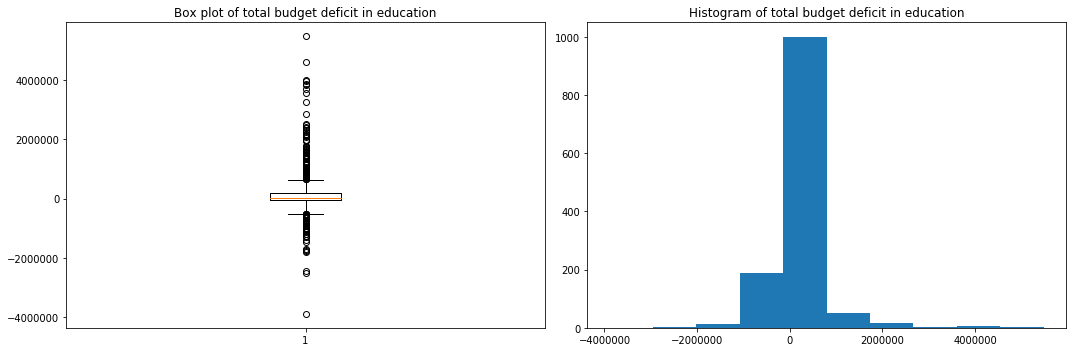

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(education["TOTAL_DEFICIT"].dropna(), whis=2)
plt.title("Box plot of total budget deficit in education")

plt.subplot(1, 2, 2)
plt.hist(education["TOTAL_DEFICIT"].dropna())
plt.title("Histogram of total budget deficit in education")

plt.tight_layout()
plt.show()

In [26]:
# Z-scores of total deficit
z_deficit = zscore(education["TOTAL_DEFICIT"].dropna())


# Set threshold to be 3
print(
    "The number of outliers (Z-score > 3) in total budget deficit is: {}".format(
        len((np.where(z_deficit > 3)[0]))
    )
)

The number of outliers (Z-score > 3) in total budget deficit is: 23


In [27]:
# 1st and 3rd quantiles of total deficit
q75_deficit, q25_deficit = np.percentile(education["TOTAL_DEFICIT"].dropna(), [75, 25])

# Interquantole range (IQR) of total deficit
iqr_deficit = q75_deficit - q25_deficit

# Set threshold to be 1.5 IQR below 1st or above 3rd quantile
min_deficit = q25_deficit - (iqr_deficit * 1.5)

max_deficit = q25_deficit + (iqr_deficit * 1.5)

print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total deficit is: {}".format(
        len(
            (
                np.where(
                    (education["TOTAL_DEFICIT"].dropna() > max_deficit)
                    | (education["TOTAL_DEFICIT"].dropna() < min_deficit)
                )[0]
            )
        )
    )
)

The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total deficit is: 289


Outliers seem to exit on both the high and the low ends. This time, we can use two-way winsorization to deal with them. Since deficits can be of negative values, it's not appropriate to use log transformation since the logarithm can only take non-negative numbers as input.

In [28]:
# Replace low and high values with 10th and 90th percentiles
winsorized_deficit = winsorize(education["TOTAL_DEFICIT"].dropna(), limits=[0.10, 0.10])

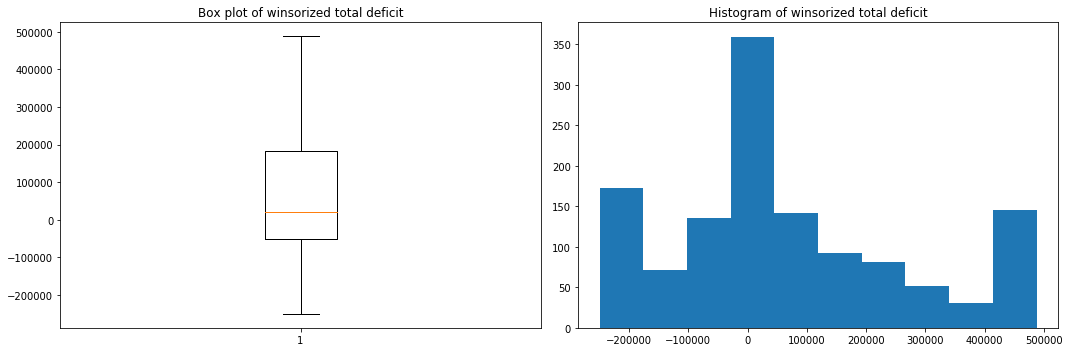

In [29]:
plt.figure(figsize=(15, 5))

# Box plot
plt.subplot(1, 2, 1)
plt.boxplot(winsorized_deficit, whis=2)
plt.title("Box plot of winsorized total deficit")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(winsorized_deficit)
plt.title("Histogram of winsorized total deficit")

plt.tight_layout()
plt.show()

In [30]:
# Z-score
print(
    "The number of outliers (Z-score > 3) in total deficit is: {}".format(
        len((np.where(zscore(winsorized_deficit) > 3)[0]))
    )
)

# IQR
print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total deficit is: {}".format(
        len(
            (
                np.where(
                    (winsorized_deficit > max_deficit)
                    | (winsorized_deficit < min_deficit)
                )[0]
            )
        )
    )
)

The number of outliers (Z-score > 3) in total deficit is: 0
The number of outliers (1.5 IQR below 1st or above 3rd quantile) in total deficit is: 204


Outliers are eliminated or at least reduced after winsorization.

4. Now create another variable by subtracting the `TOTAL_EXPENDITURE` from `TOTAL_REVENUE`. This time, use the outlier eliminated versions of `TOTAL_EXPENDITURE` from `TOTAL_REVENUE`. In this newly created variable, can you find any outliers? If so, eliminate them.

We can use winsorized revenue and expenditure to create a new version of total deficit.

In [33]:
deficit = winsorized_revenue - winsorized_expend

Detect outliers.

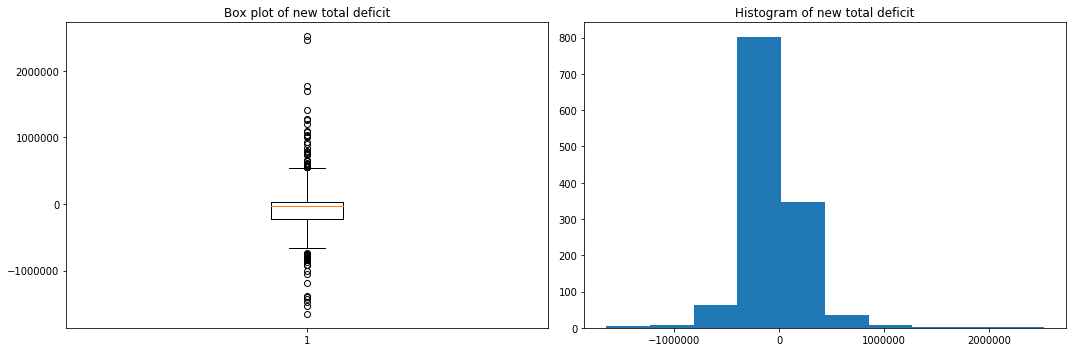

In [34]:
plt.figure(figsize=(15, 5))

# Box plot
plt.subplot(1, 2, 1)
plt.boxplot(deficit, whis=2)
plt.title("Box plot of new total deficit")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(deficit)
plt.title("Histogram of new total deficit")

plt.tight_layout()
plt.show()

In [35]:
# Z-score
print(
    "The number of outliers (Z-score > 3) in new total deficit is: {}".format(
        len((np.where(zscore(deficit) > 3)[0]))
    )
)

# IQR

# 1st and 3rd quantiles of new total deficit
q75_deficit2, q25_deficit2 = np.percentile(deficit, [75, 25])

# Interquantole range (IQR) of total deficit
iqr_deficit2 = q75_deficit2 - q25_deficit2

# Set threshold to be 1.5 IQR below 1st or above 3rd quantile
min_deficit2 = q25_deficit2 - (iqr_deficit2 * 1.5)

max_deficit2 = q25_deficit2 + (iqr_deficit2 * 1.5)

print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in new total deficit is: {}".format(
        len((np.where((deficit > max_deficit2) | (deficit < min_deficit2))[0]))
    )
)

The number of outliers (Z-score > 3) in new total deficit is: 15
The number of outliers (1.5 IQR below 1st or above 3rd quantile) in new total deficit is: 187


Apparently, even though we have eliminated outliers in the two input columns, the output can still have outliers. Let's eliminate those using two-way winsorization and check the results.

In [36]:
# Replace low and high values with 10th and 90th percentiles
winsorized_deficit2 = winsorize(deficit, limits=[0.10, 0.10])

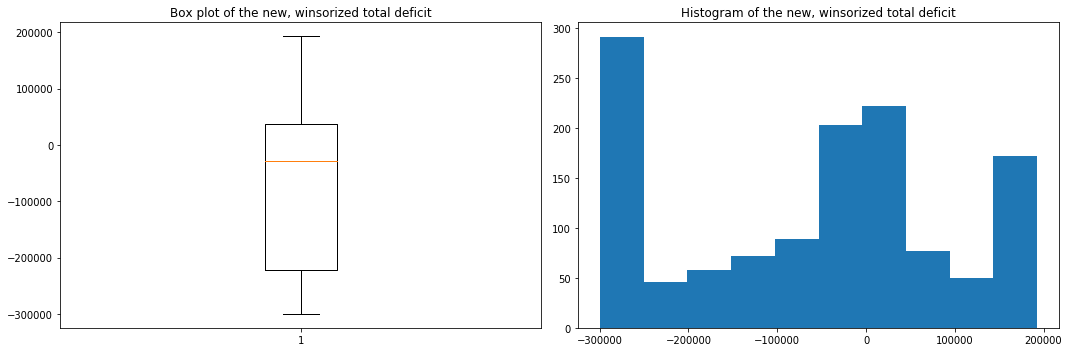

In [37]:
plt.figure(figsize=(15, 5))

# Box plot
plt.subplot(1, 2, 1)
plt.boxplot(winsorized_deficit2, whis=2)
plt.title("Box plot of the new, winsorized total deficit")

# Histogram
plt.subplot(1, 2, 2)
plt.hist(winsorized_deficit2)
plt.title("Histogram of the new, winsorized total deficit")

plt.tight_layout()
plt.show()

In [38]:
# Z-score
print(
    "The number of outliers (Z-score > 3) in new, winsorized total deficit is: {}".format(
        len((np.where(zscore(winsorized_deficit2) > 3)[0]))
    )
)

# IQR
print(
    "The number of outliers (1.5 IQR below 1st or above 3rd quantile) in new, winsorized total deficit is: {}".format(
        len(
            (
                np.where(
                    (winsorized_deficit2 > max_deficit2)
                    | (winsorized_deficit2 < min_deficit2)
                )[0]
            )
        )
    )
)

The number of outliers (Z-score > 3) in new, winsorized total deficit is: 0
The number of outliers (1.5 IQR below 1st or above 3rd quantile) in new, winsorized total deficit is: 153


Outliers are eliminated or at least reduced.

5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

Before winsorization, the budget deficit variable created in the 4th question already has less extreme max and min values compared to that from the 3rd question. This is understandable given that in the 4th question, we first eliminated outliers in total revenue and total expenditure before performing the subtraction. Both the central tendency (mean) and the variance (standard deviation) are drastically different between the two variables.

In [44]:
# From the 3rd question
education['TOTAL_DEFICIT'].describe()

count    1.280000e+03
mean     1.045990e+05
std      5.734045e+05
min     -3.897129e+06
25%     -5.130425e+04
50%      2.148400e+04
75%      1.816858e+05
max      5.487742e+06
Name: TOTAL_DEFICIT, dtype: float64

In [48]:
# From the 4th question
pd.Series(deficit).describe()

count    8.000000e+00
mean     3.893202e+05
std      1.179201e+06
min     -1.650831e+06
25%     -2.147455e+03
50%      2.484235e+05
75%      7.263005e+05
max      2.520706e+06
dtype: float64

After the winsorization, the two variables also differ on almost all descriptive stats. Generally, the variable from the 4th question seems to take lower values than that from the 3rd question.

In [49]:
# From the 3rd question
pd.Series(winsorized_deficit).describe()

count      1280.000000
mean      65660.782031
std      211192.202949
min     -249996.000000
25%      -51304.250000
50%       21484.000000
75%      181685.750000
max      487915.000000
dtype: float64

In [50]:
# From the 4th question
pd.Series(winsorized_deficit2).describe()

count      1280.000000
mean     -60815.457031
std      158693.405939
min     -299828.000000
25%     -221944.500000
50%      -28430.000000
75%       36918.500000
max      192793.000000
dtype: float64

6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

I think the method is the 3rd question is more appropriate. Every time we perform winsorization, we lose information about the extreme values. Since we only care about extreme values in the budget deficit variable, it seems wasteful to winsorize total revenue and total expenditure first. We can use the raw values of these variables to calculate deficit and then perform winsori